# Data Augmentation
## Imports and Version Selection


In [0]:
# TensorFlow ≥2.0 is required for this notebook
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# check if GPU is available as this notebook will be very slow without GPU
if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

# jupyters magic command
%matplotlib inline

     |████████████████████████████████| 399kB 1.9MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.18-py2.py3-none-any.whl size=8393 sha256=7f22d9ed48a0958b72eb8c6bfdeceef4b4ca0e3c373b3189bb7cc9f21d4fd1ef
  Stored in directory: /root/.cache/pip/wheels/c9/24/f5/8258a898fd2cd12315ca220f208be60cc08dc29bc6bd73a0df
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=d41f256a9fa42458c7bf06162e549d33ba3bb60cebca12e173aeaab601ef88fa
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


In [0]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

## Loading and Preprocessing

In [0]:
# download the dataset with labels and with information about the data
data, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# print the most important information
dataset_size = info.splits['train'].num_examples
print('dataset size: ', dataset_size)
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

batch_size = 32

try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
  test_data = tfds.load('tf_flowers', split="train[80%:100%]", as_supervised=True)
  train_data = train_data.shuffle(1000)
  test_data = test_data
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True)
  test_data = tfds.load('tf_flowers', split=test_split, as_supervised=True)
  train_data = train_data.shuffle(1000)
  test_data = test_data
  
# convert tf.dataset to numpy array
X, y, X_test, y_test = helpers.dataset_to_ndarray(train_data, test_data)

dataset size:  3670
class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
number of classes:  5


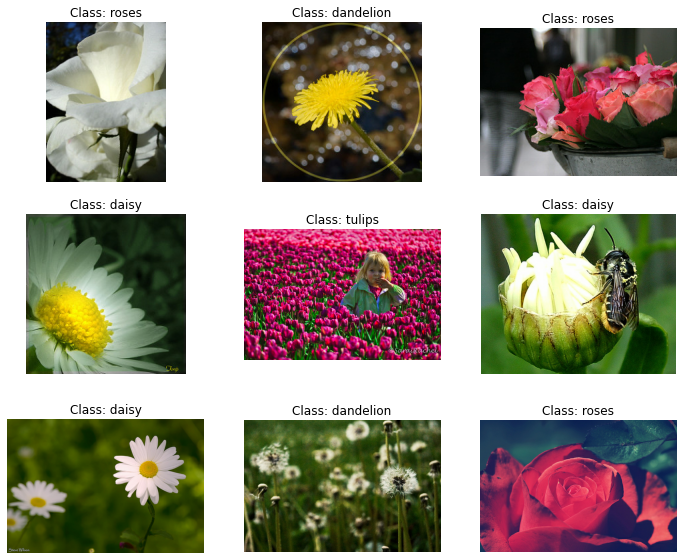

In [0]:
# show some images from the dataset
helpers.plot_images(train_data.take(9).map(lambda x, y: (x / 255, y)), class_names)

## Definition and Training

In [0]:
# returns a standard CNN with provided or default parameters
def make_model(
  learning_rate=0.0001,
  momentum=0.9,
  decay=0.002,
  dense_neurons=1000,
  n_filters=32,
  first_kernel_size=(7,7),
  activation='elu',
  noise=False
):

  # Images must have 224x224 px and RGB color
  input_layer = Input(shape=(224, 224, 3))
  input = input_layer

  # Include noise as data augmentation technique
  if noise:
    input = GaussianNoise(0.1)(input_layer)

  # Convolutional Neural Network
  # It consists of 5 stacked Convolutional Layers with Max Pooling
  model = Conv2D(
      filters=n_filters, 
      kernel_size=(7,7), 
      activation=activation
      )(input)
  model = MaxPooling2D((2,2))(model)

  for i in range(2, 5):
    model = Conv2D(
        filters = i * n_filters, 
        kernel_size=(3,3), 
        activation=activation
      )(model)
    model = MaxPooling2D((2,2))(model)

  model = Conv2D(filters = 5 * n_filters, 
    kernel_size=(3,3), 
    activation=activation, 
    padding='same'
  )(model)
  model = MaxPooling2D((2,2))(model)

  # Fully-Connected-Classifier
  model = Flatten()(model)
  model = Dense(dense_neurons, activation=activation)(model)

  model = Dense(dense_neurons / 2, activation=activation)(model)

  # Output Layer
  output = Dense(n_classes, activation="softmax")(model)

  CNN_model = Model(input_layer, output)

  # Compile model
  optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum) #, decay=decay)
  CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
  
  return CNN_model


In [0]:
make_model().summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 107, 107, 64)      18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 51, 51, 96)        55392     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 25, 25, 96)        0   

In [0]:
# Define an image generator which only rescales pictures
generator = tf.keras.preprocessing.image.ImageDataGenerator()
# generate iterator over generated images from existing images
train_iterator = generator.flow(X, y)
test_iterator = generator.flow(X_test, y_test)


In [0]:
# train the model without data augmentation
CNN_model = make_model()
history = CNN_model.fit(
    train_iterator,
    steps_per_epoch=92,
    epochs=40,
    validation_data=test_iterator,
    validation_steps=23
)

Epoch 1/40
92/92 [==============================] - 4s 41ms/step - loss: 1.5277 - accuracy: 0.3375 - val_loss: 1.4547 - val_accuracy: 0.3992
Epoch 2/40
92/92 [==============================] - 4s 40ms/step - loss: 1.3897 - accuracy: 0.4251 - val_loss: 1.3158 - val_accuracy: 0.4837
Epoch 3/40
92/92 [==============================] - 4s 40ms/step - loss: 1.2851 - accuracy: 0.4676 - val_loss: 1.2439 - val_accuracy: 0.4796
Epoch 4/40
92/92 [==============================] - 4s 40ms/step - loss: 1.2262 - accuracy: 0.4877 - val_loss: 1.1742 - val_accuracy: 0.5286
Epoch 5/40
92/92 [==============================] - 4s 40ms/step - loss: 1.1912 - accuracy: 0.5075 - val_loss: 1.1747 - val_accuracy: 0.5191
Epoch 6/40
92/92 [==============================] - 4s 40ms/step - loss: 1.1643 - accuracy: 0.5143 - val_loss: 1.1459 - val_accuracy: 0.5640
Epoch 7/40
92/92 [==============================] - 4s 41ms/step - loss: 1.1408 - accuracy: 0.5317 - val_loss: 1.1230 - val_accuracy: 0.5654
Epoch 8/40
92

In [0]:
# Create an image generator with different data augmentation techniques
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    # vertical_flip=True
)

# generate an image iterator over augmented images from the training data
train_iterator = generator.flow(X, y)

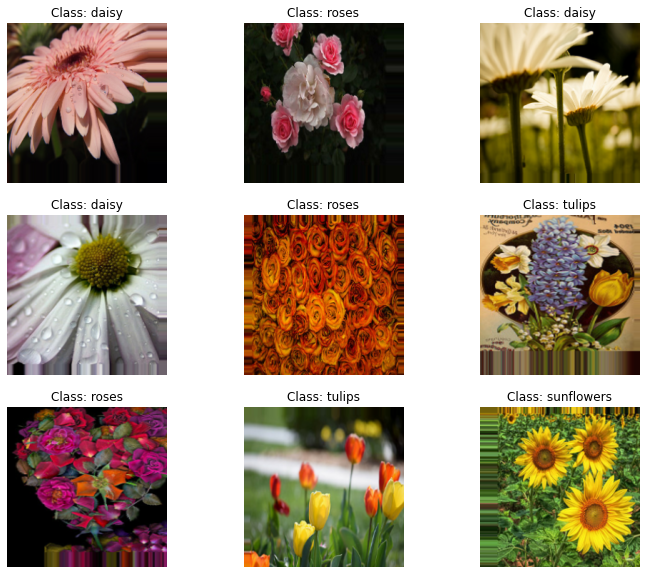

In [0]:
# plot some augmented images
X_augmented, y_augmented = next(train_iterator)
helpers.plot_images_with_labels((X_augmented + 1) / 2, y_augmented, class_names)

In [0]:
# train a model with data augmentation and noise
data_augmentation_model = make_model(learning_rate=0.001, noise=True)
history_data_augmentation = data_augmentation_model.fit(
    train_iterator,
    steps_per_epoch=92,
    epochs=40,
    validation_data=test_iterator,
    validation_steps=23
)

Epoch 1/40
92/92 [==============================] - 26s 284ms/step - loss: 1.3502 - accuracy: 0.4131 - val_loss: 1.1804 - val_accuracy: 0.4891
Epoch 2/40
92/92 [==============================] - 26s 288ms/step - loss: 1.1646 - accuracy: 0.5290 - val_loss: 1.0505 - val_accuracy: 0.5886
Epoch 3/40
92/92 [==============================] - 26s 286ms/step - loss: 1.0675 - accuracy: 0.5800 - val_loss: 1.1554 - val_accuracy: 0.5286
Epoch 4/40
92/92 [==============================] - 26s 286ms/step - loss: 1.0385 - accuracy: 0.6025 - val_loss: 0.9594 - val_accuracy: 0.6458
Epoch 5/40
92/92 [==============================] - 26s 287ms/step - loss: 0.9979 - accuracy: 0.6144 - val_loss: 0.9840 - val_accuracy: 0.6008
Epoch 6/40
92/92 [==============================] - 26s 285ms/step - loss: 0.9773 - accuracy: 0.6185 - val_loss: 0.9159 - val_accuracy: 0.6226
Epoch 7/40
92/92 [==============================] - 26s 285ms/step - loss: 0.9210 - accuracy: 0.6465 - val_loss: 0.8603 - val_accuracy: 0.6621

## Visualization and Evaluation

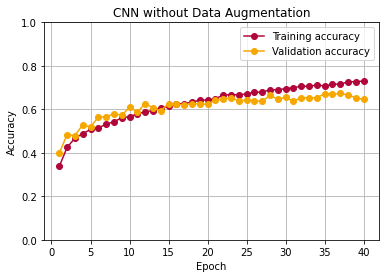

In [0]:
helpers.plot_history('CNN without Data Augmentation', history, 0)

# validation accuracy might be sometimes higher than training accuracy due to 2 reasons:
#     - train acc is calculated as the mean of the whole epoch, test acc is calculated after each epoch
#       (where the model is better than in the mid of the epoch)
#     - when you use e.g. Dropout or aggressive data augmentation, the behavior at training time is different 

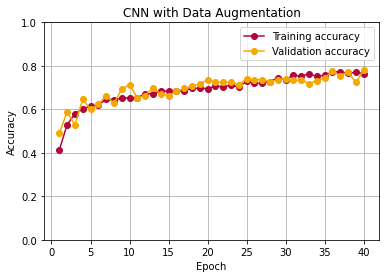

In [0]:
helpers.plot_history('CNN with Data Augmentation', history_data_augmentation, 0)